## Viola-Jones

In [1]:
import numpy as np
import cv2 as cv
import random
import math
from os import listdir
from os.path import isfile, join
from sklearn.feature_selection import SelectPercentile, f_classif
import matplotlib.pyplot as plt

##  Integral Image

In [2]:
def integral_image(image):
    s = np.zeros(image.shape)
    ii = np.zeros(image.shape)
    height, width = image.shape
    for y in range(height):
        for x in range(width):
            if(y==0):
                s[y][x] = image[y][x]
            else:
                s[y][x] = s[y-1][x] + image[y][x]
            
            if(x==0):
                ii[y][x] = s[y][x]
            else:
                ii[y][x] = ii[y][x-1] + s[y][x]
    return ii       

## Sum of features in a Rectangular region

In [3]:
def rectangular_sum(ii,pos):
    x = pos[0]
    y = pos[1]
    w = pos[2]
    h = pos[3]
    bottom_right = ii[y+h][x+w]
    top_left = ii[y][x]
    bottom_left = ii[y+h][x]
    top_right = ii[y][x+w]
    features_rectangle_sum = (bottom_right+top_left) - (bottom_left+top_right)
    return features_rectangle_sum

## Haar features

In [4]:
def haar_features(image_shape):
    height, width = image_shape
    features = []
    for h in range(1,height):
        for w in range(1,width):
            y = 0
            while(y+h<height):
                x = 0
                while(x+w<width):
                    current = x,y,w,h
                    
                    #Edge features
                    if(x+2*w<width):
                        right = x+w,y,w,h
                        features.append(([right],[current]))
                    if(y+2*h<height):
                        bottom = x,y+h,w,h
                        features.append(([current],[bottom]))
                        
                    #Line features
                    if(x+3*w<width):
                        rightmost = x+2*w,y,w,h
                        features.append(([right],[rightmost,current]))
                    if(y+3*h<height):
                        bottommost = x,y+2*h,w,h
                        features.append(([bottom],[bottommost,current]))
                        
                    #Rectangular features
                    if(x+2*w<width and y+2*h<height):
                        bottom_right = x+w,y+h,w,h
                        features.append(([right,bottom],[current,bottom_right]))
                    
                    x = x+1
                y = y+1
    return features

## Training

In [5]:
def train(integral_images, labels, pos_examples, neg_examples):
    image_shape = integral_images[0].shape
    weights = np.zeros(len(labels))
    features = haar_features(image_shape)
    X = np.zeros((len(features),len(labels)))
    for x in range(len(labels)):  
        if labels[x] == 1:
            weights[x] = 1.0/(2*pos_examples)
        else:
            weights[x] = 1.0/(2*neg_examples)
        
    for i in range(len(features)):
        for j in range(len(integral_images)):
            ii = integral_images[j]
            positive_features_sum = sum([rectangular_sum(ii,pos) for pos in features[i][0]])
            negative_features_sum = sum([rectangular_sum(ii,neg) for neg in features[i][1]])
            feature_value = positive_features_sum - negative_features_sum
            X[i][j] = feature_value
                
    return weights, X

## Selecting Best classifier

In [6]:
def select_best_classifier(weights,X,y):
    num_features, num_img = X.shape
    total_pos_weights = 0
    total_neg_weights = 0
    final_error_arr = np.zeros(num_img)
    
    for i in range(num_img):
        if y[i]==1:
            total_pos_weights+=weights[i]
        else:
            total_neg_weights+=weights[i]
    
    final_feature_error = np.inf
    final_feature, final_threshold, final_polarity = None, None, None
    
    for i in range(num_features):
        total = sorted(zip(weights, X[i,:], y), key=lambda x: x[1])
    
        pos_weights, neg_weights = 0, 0
        pos_seen, neg_seen = 0, 0
        min_error = np.inf
        polarity, threshold = None, None
    
        for w, f, label in total :
            
            term_1 = neg_weights + total_pos_weights - pos_weights
            term_2 = pos_weights + total_neg_weights - neg_weights
            error = min(term_1,term_2)
        
            if error<min_error :
                min_error = error
                threshold = f
                if pos_seen>neg_seen:
                    polarity = 1
                else :
                    polarity = -1
            
                    
            if label == 1:
                pos_seen+=1
                pos_weights+=w
            else:
                neg_seen+=1
                neg_weights+=w
                
        
        feature_error = 0
        error_arr = np.zeros(num_img)
        for x in range(num_img):
            feature_val = X[i,x]
            if y[x] == 0 and polarity*feature_val < polarity*threshold :
                feature_error += weights[x]
                error_arr[x] = 1
            if y[x] == 1 and polarity*feature_val >= polarity*threshold :
                feature_error += weights[x]
                error_arr[x] = 1
                
        if feature_error<final_feature_error:
            final_feature_error = feature_error
            final_feature = i
            final_polarity = polarity
            final_threshold = threshold
            final_error_arr = error_arr
    
    return final_feature_error, final_feature, final_polarity, final_threshold, final_error_arr

## Test

In [7]:
def test(beta, threshold, polarity, best_classifier, integral_images, y):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    num_imgs = len(integral_images)
    features = haar_features(integral_images[0].shape)
    
    for i in range(num_imgs):
        val = 0
        sum_alpha = 0
        for j in range(len(best_classifier)):
            feature_idx = best_classifier[j]
            ii = integral_images[i]
            positive_features_sum = sum([rectangular_sum(ii,pos) for pos in features[feature_idx][0]])
            negative_features_sum = sum([rectangular_sum(ii,neg) for neg in features[feature_idx][1]])
            feature_value = positive_features_sum - negative_features_sum
            
            p = polarity[j]
            th = threshold[j]
            sum_alpha = sum_alpha + math.log(1/beta[j])
            
            if p*feature_value < p*th :
                val += math.log(1/beta[j])

        if val >= 0.5*sum_alpha and y[i] == 1 :
            tp = tp+1
        if val < 0.5*sum_alpha and y[i] == 0 :
            tn = tn+1
        if val >= 0.5*sum_alpha and y[i] == 0 :
            fp = fp+1
        if val < 0.5*sum_alpha and y[i] == 1 :
            fn = fn+1

    return tp, tn, fp, fn

## Test on Single Image

In [8]:
def test_single_image(beta, threshold, polarity, best_classifier, integral_images, y):
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    features = haar_features(integral_images.shape)

    val = 0
    sum_alpha = 0
    for j in range(len(best_classifier)):
        feature_idx = best_classifier[j]
        ii = integral_images
        positive_features_sum = sum([rectangular_sum(ii,pos) for pos in features[feature_idx][0]])
        negative_features_sum = sum([rectangular_sum(ii,neg) for neg in features[feature_idx][1]])
        feature_value = positive_features_sum - negative_features_sum

        p = polarity[j]
        th = threshold[j]
        sum_alpha = sum_alpha + math.log(1/beta[j])

        if p*feature_value < p*th :
            val += math.log(1/beta[j])

    if val >= 0.5*sum_alpha and y == 1 :
        tp = tp+1
    if val < 0.5*sum_alpha and y == 0 :
        tn = tn+1
    if val >= 0.5*sum_alpha and y == 0 :
        fp = fp+1
    if val < 0.5*sum_alpha and y == 1 :
        fn = fn+1

    return tp, tn, fp, fn

## Do not run unless you want to retrain the model

In [9]:
'''img_size = 18

train_faces_img_path = "../dataset/train/face/"
train_non_faces_img_path = "../dataset/train/non-face/"

train_faces_img = [f for f in listdir(train_faces_img_path) if isfile(join(train_faces_img_path, f))][:1000]
train_non_faces_img = [f for f in listdir(train_non_faces_img_path) if isfile(join(train_non_faces_img_path, f))][:1000]

num_train_faces = len(train_faces_img)
num_train_non_faces = len(train_non_faces_img)
num_train_img = num_train_faces + num_train_non_faces

labels_train = np.zeros(num_train_img)
integral_images_train = []

pos_examples = 0
for f in train_faces_img:
    img = cv.imread(train_faces_img_path+f,0)
    img = cv.resize(img,(img_size,img_size))
    integral_images_train.append(integral_image(img))  
    labels_train[pos_examples] = 1
    pos_examples  = pos_examples  + 1

neg_examples = 0
for f in train_non_faces_img:
    img = cv.imread(train_non_faces_img_path+f,0)
    img = cv.resize(img,(img_size,img_size))
    integral_images_train.append(integral_image(img))
    labels_train[pos_examples+neg_examples] = 0
    neg_examples = neg_examples + 1

training_data = list(zip(integral_images_train,labels_train)) 
random.shuffle(training_data)
for i in range(len(training_data)):
    integral_images_train[i] = training_data[i][0]
    labels_train[i] = training_data[i][1]
    
weights, X = train(integral_images_train, labels_train, pos_examples, neg_examples)'''

'img_size = 18\n\ntrain_faces_img_path = "../dataset/train/face/"\ntrain_non_faces_img_path = "../dataset/train/non-face/"\n\ntrain_faces_img = [f for f in listdir(train_faces_img_path) if isfile(join(train_faces_img_path, f))][:1000]\ntrain_non_faces_img = [f for f in listdir(train_non_faces_img_path) if isfile(join(train_non_faces_img_path, f))][:1000]\n\nnum_train_faces = len(train_faces_img)\nnum_train_non_faces = len(train_non_faces_img)\nnum_train_img = num_train_faces + num_train_non_faces\n\nlabels_train = np.zeros(num_train_img)\nintegral_images_train = []\n\npos_examples = 0\nfor f in train_faces_img:\n    img = cv.imread(train_faces_img_path+f,0)\n    img = cv.resize(img,(img_size,img_size))\n    integral_images_train.append(integral_image(img))  \n    labels_train[pos_examples] = 1\n    pos_examples  = pos_examples  + 1\n\nneg_examples = 0\nfor f in train_non_faces_img:\n    img = cv.imread(train_non_faces_img_path+f,0)\n    img = cv.resize(img,(img_size,img_size))\n    int

In [10]:
"""indices = SelectPercentile(f_classif, percentile=10).fit(X.T,labels_train).get_support(indices=True)
X_indices = X[indices]
beta = []
threshold = []
polarity = [] 
best_classifier = []

T = 10
for i in range(T):
    weights = weights/sum(weights)
    final_feature_error, final_feature, final_polarity, final_threshold, final_error_arr = select_best_classifier(weights,X,labels_train)
    best_classifier.append(final_feature)
    polarity.append(final_polarity)
    threshold.append(final_threshold)
    beta_val = final_feature_error/(1-final_feature_error)
    beta.append(beta_val)
    for j in range(len(weights)):
        weights[j] = weights[j]*(beta_val**(1-(final_error_arr[j])))"""

'indices = SelectPercentile(f_classif, percentile=10).fit(X.T,labels_train).get_support(indices=True)\nX_indices = X[indices]\nbeta = []\nthreshold = []\npolarity = [] \nbest_classifier = []\n\nT = 10\nfor i in range(T):\n    weights = weights/sum(weights)\n    final_feature_error, final_feature, final_polarity, final_threshold, final_error_arr = select_best_classifier(weights,X,labels_train)\n    best_classifier.append(final_feature)\n    polarity.append(final_polarity)\n    threshold.append(final_threshold)\n    beta_val = final_feature_error/(1-final_feature_error)\n    beta.append(beta_val)\n    for j in range(len(weights)):\n        weights[j] = weights[j]*(beta_val**(1-(final_error_arr[j])))'

In [11]:
"""np.save( "./beta.npy",beta)
np.save( "./threshold.npy",threshold)
np.save( "./polarity.npy",polarity)
np.save("./best_classifier.npy",best_classifier)"""

'np.save( "./beta.npy",beta)\nnp.save( "./threshold.npy",threshold)\nnp.save( "./polarity.npy",polarity)\nnp.save("./best_classifier.npy",best_classifier)'

In [12]:
beta = np.load( "./beta.npy")
threshold = np.load( "./threshold.npy")
polarity = np.load( "./polarity.npy")
best_classifier = np.load("./best_classifier.npy")

## Running the Viola Jones on Train Data

In [13]:
img_size = 18

train_faces_img_path = "../dataset/train/face/"
train_non_faces_img_path = "../dataset/train/non-face/"

train_faces_img = [f for f in listdir(train_faces_img_path) if isfile(join(train_faces_img_path, f))][:1000]
train_non_faces_img = [f for f in listdir(train_non_faces_img_path) if isfile(join(train_non_faces_img_path, f))][:1000]

num_train_faces = len(train_faces_img)
num_train_non_faces = len(train_non_faces_img)
num_train_img = num_train_faces + num_train_non_faces

labels_train = np.zeros(num_train_img)
integral_images_train = []

pos_examples = 0
for f in train_faces_img:
    img = cv.imread(train_faces_img_path+f,0)
    img = cv.resize(img,(img_size,img_size))
    integral_images_train.append(integral_image(img))  
    labels_train[pos_examples] = 1
    pos_examples  = pos_examples  + 1

neg_examples = 0
for f in train_non_faces_img:
    img = cv.imread(train_non_faces_img_path+f,0)
    img = cv.resize(img,(img_size,img_size))
    integral_images_train.append(integral_image(img))
    labels_train[pos_examples+neg_examples] = 0
    neg_examples = neg_examples + 1

training_data = list(zip(integral_images_train,labels_train)) 
random.shuffle(training_data)
for i in range(len(training_data)):
    integral_images_train[i] = training_data[i][0]
    labels_train[i] = training_data[i][1]

In [14]:
tp, tn, fp, fn = test(beta, threshold, polarity, best_classifier, integral_images_train, labels_train)
print("Testing the algo on Training Data ...")
print("True positive/Actual Positive = ",tp,"/",num_train_faces)
print("True Negative/Actual Negative = ",tn,"/",num_train_non_faces)
print("False positive = ",fp)
print("False Negative = ",fn)
print("Accuracy in training = ",100*(tp+tn)/num_train_img,"%")
print("Precision in training = ",100*tp/(tp+fp),"%")
print("Recall in training = ",100*tp/(tp+fn),"%")

Testing the algo on Training Data ...
True positive/Actual Positive =  973 / 1000
True Negative/Actual Negative =  961 / 1000
False positive =  39
False Negative =  27
Accuracy in training =  96.7 %
Precision in training =  96.14624505928853 %
Recall in training =  97.3 %


## Running Viola Jones on Validation data

In [15]:
img_size = 18

validate_faces_img_path = "../dataset/train/face/"
validate_non_faces_img_path = "../dataset/train/non-face/"

validate_faces_img = [f for f in listdir(train_faces_img_path) if isfile(join(train_faces_img_path, f))][1000:2000]
validate_non_faces_img = [f for f in listdir(train_non_faces_img_path) if isfile(join(train_non_faces_img_path, f))][1001:2001]

num_validate_faces = len(validate_faces_img)
num_validate_non_faces = len(validate_non_faces_img)
num_validate_img = num_validate_faces + num_validate_non_faces

labels_validate = np.zeros(num_validate_img)
integral_images_validate = []

pos_examples = 0
for f in validate_faces_img:
    img = cv.imread(validate_faces_img_path+f,0)
    img = cv.resize(img,(img_size,img_size))
    integral_images_validate.append(integral_image(img))  
    labels_validate[pos_examples] = 1
    pos_examples  = pos_examples  + 1

neg_examples = 0
for f in validate_non_faces_img:
    img = cv.imread(validate_non_faces_img_path+f,0)
    img = cv.resize(img,(img_size,img_size))
    integral_images_validate.append(integral_image(img))
    labels_validate[pos_examples+neg_examples] = 0
    neg_examples = neg_examples + 1

validation_data = list(zip(integral_images_validate,labels_validate)) 
random.shuffle(validation_data)
for i in range(len(validation_data)):
    integral_images_validate[i] = validation_data[i][0]
    labels_validate[i] = validation_data[i][1]

In [16]:
tp, tn, fp, fn = test(beta, threshold, polarity, best_classifier, integral_images_validate, labels_validate)
print("Testing the algo on Validation Data ...")
print("True positive/Actual Positive = ",tp,"/",num_validate_faces)
print("True Negative/Actual Negative = ",tn,"/",num_validate_non_faces)
print("False positive = ",fp)
print("False Negative = ",fn)
print("Accuracy in validation = ",100*(tp+tn)/num_train_img,"%")
print("Precision in validation = ",100*tp/(tp+fp),"%")
print("Recall in validation = ",100*tp/(tp+fn),"%")

Testing the algo on Validation Data ...
True positive/Actual Positive =  958 / 1000
True Negative/Actual Negative =  933 / 1000
False positive =  67
False Negative =  42
Accuracy in validation =  94.55 %
Precision in validation =  93.46341463414635 %
Recall in validation =  95.8 %


## Running the Viola Jones on Test Data

In [17]:
img_size = 18

test_faces_img_path = "../dataset/test/face/"
test_non_faces_img_path = "../dataset/test/non-face/"
test_faces_img = [f for f in listdir(test_faces_img_path) if isfile(join(test_faces_img_path, f))]
test_non_faces_img = [f for f in listdir(test_non_faces_img_path) if isfile(join(test_non_faces_img_path, f))][:1500]
num_test_faces = len(test_faces_img)
num_test_non_faces = len(test_non_faces_img)
num_test_img = num_test_faces + num_test_non_faces

labels_test = np.zeros(num_test_img)
integral_images_test = []

pos_examples = 0
for f in test_faces_img:
    img = cv.imread(test_faces_img_path+f,0)
    img = cv.resize(img,(img_size,img_size))
    integral_images_test.append(integral_image(img))  
    labels_test[pos_examples] = 1
    pos_examples  = pos_examples  + 1

neg_examples = 0
for f in test_non_faces_img:
    img = cv.imread(test_non_faces_img_path+f,0)
    img = cv.resize(img,(img_size,img_size))
    integral_images_test.append(integral_image(img))
    labels_test[pos_examples+neg_examples] = 0
    neg_examples = neg_examples + 1

test_data = list(zip(integral_images_test,labels_test)) 
random.shuffle(test_data)
for i in range(len(test_data)):
    integral_images_test[i] = test_data[i][0]
    labels_test[i] = test_data[i][1]

In [18]:
tp,tn,fp,fn = test(beta, threshold, polarity, best_classifier, integral_images_test, labels_test)
print("Testing the algo on Test Data ...")
print("True positive/Actual Positive = ",tp,"/",num_test_faces)
print("True Negative/Actual Negative = ",tn,"/",num_test_non_faces)
print("False positive = ",fp)
print("False Negative = ",fn)
print("Accuracy in testing = ",100*(tp+tn)/num_test_img,"%")
print("Precision in testing = ",100*tp/(tp+fp),"%")
print("Recall in testing = ",100*tp/(tp+fn),"%")

Testing the algo on Test Data ...
True positive/Actual Positive =  141 / 472
True Negative/Actual Negative =  1421 / 1500
False positive =  79
False Negative =  331
Accuracy in testing =  79.20892494929006 %
Precision in testing =  64.0909090909091 %
Recall in testing =  29.872881355932204 %


## Images and their classification using Viola Jones

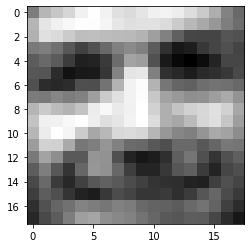

TRUE Face detected


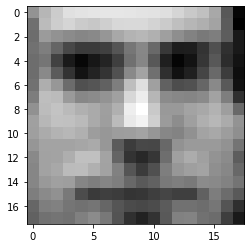

TRUE Face detected


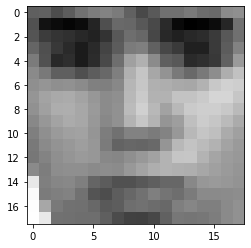

TRUE Face detected


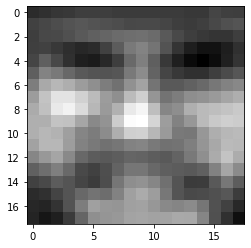

TRUE Face detected


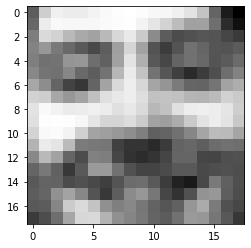

TRUE Face detected


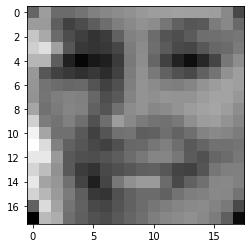

TRUE Face detected


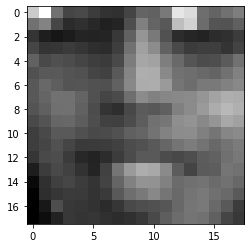

FALSE Face not detected


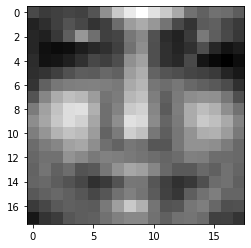

TRUE Face detected


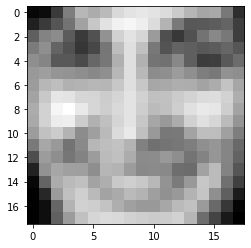

TRUE Face detected


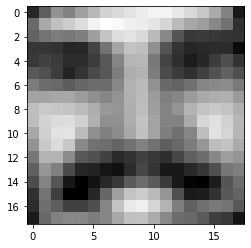

TRUE Face detected


In [19]:
for n_i in range(10):
    train_faces_img_path = "../dataset/train/face/"
    train_faces_img = [f for f in listdir(train_faces_img_path) if isfile(join(train_faces_img_path, f))][n_i]
    img = cv.imread(train_faces_img_path+train_faces_img,0)
    img = cv.resize(img,(img_size,img_size))
    plt.imshow(img,cmap='gray')
    plt.show()
    tp,tn,fp,fn = test_single_image(beta, threshold, polarity, best_classifier, integral_image(img), 1)
    if tp == 1 :
        print("TRUE Face detected")
    elif fn == 1 :
        print("FALSE Face not detected")

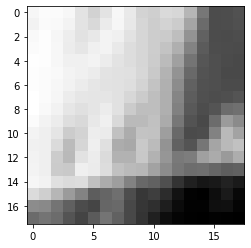

TRUE Face NOT detected


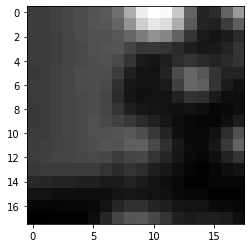

TRUE Face NOT detected


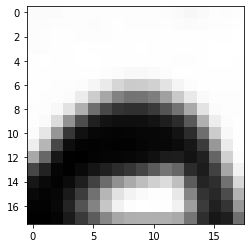

TRUE Face NOT detected


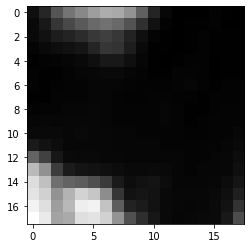

TRUE Face NOT detected


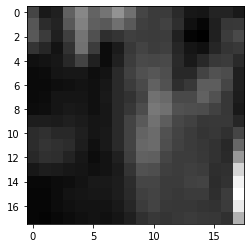

TRUE Face NOT detected


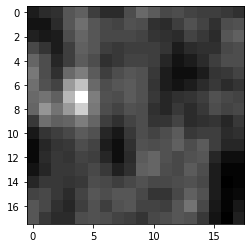

TRUE Face NOT detected


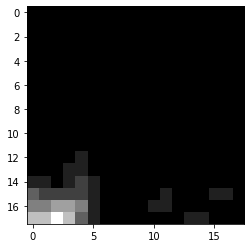

TRUE Face NOT detected


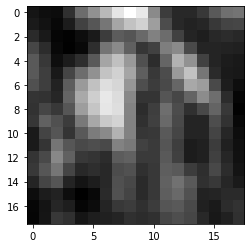

TRUE Face NOT detected


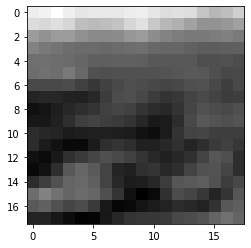

TRUE Face NOT detected


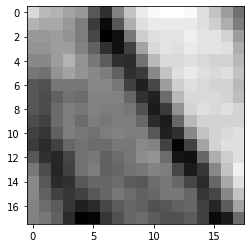

TRUE Face NOT detected


In [20]:
for n_i in range(10):
    train_non_faces_img_path = "../dataset/train/non-face/"
    train_non_faces_img = [f for f in listdir(train_non_faces_img_path) if isfile(join(train_non_faces_img_path, f))][n_i]
    img = cv.imread(train_non_faces_img_path+train_non_faces_img,0)
    img = cv.resize(img,(img_size,img_size))
    plt.imshow(img,cmap='gray')
    plt.show()
    tp,tn,fp,fn = test_single_image(beta, threshold, polarity, best_classifier, integral_image(img), 0)
    if tn == 1 :
        print("TRUE Face NOT detected")
    elif fn == 1 :
        print("FALSE Face not detected falsely")

## Viola Jones Face detection on my selfie 

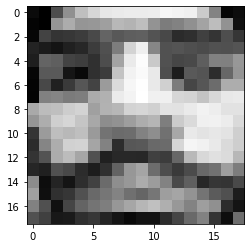

TRUE Face detected


In [21]:
selfie_face_img_path = "../karan.jpeg"
img = cv.imread(selfie_face_img_path,0)
img = cv.resize(img,(img_size,img_size))
plt.imshow(img,cmap='gray')
plt.show()
tp,tn,fp,fn = test_single_image(beta, threshold, polarity, best_classifier, integral_image(img), 1)
if tp == 1 :
    print("TRUE Face detected")
elif fn == 1 :
    print("FALSE Face not detected")